In [1]:
from load_dataset import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
class Fusion_Model(nn.Module):
    def __init__(self):
        super(Fusion_Model, self).__init__()
    
    def forward(self, batch, ref_imgs, emb_imgs):
        x = F.conv2d(ref_imgs, emb_imgs, groups=batch)
        x = x.float()
        Normal = nn.BatchNorm2d(batch)
        x = Normal(x)
        x = F.softmax(x, dim=3)
        result = torch.max(x, 3)
        
        return x, result

In [3]:
def correlate(ref_RGB_list, emb_RGB_list, ref_IR_list, emb_IR_list, para, W_origin, cut_area=0.75):
    batch, C_RGB, C_IR, H, W_emb, W_ref = para
    
    ref_IR_list = torch.from_numpy(ref_IR_list).reshape(1, C_IR*batch, H, W_ref).to(device)
    emb_IR_list = torch.from_numpy(emb_IR_list).reshape(batch, C_IR, H, W_emb).to(device)

    ref_RGB_list = torch.from_numpy(ref_RGB_list).reshape(1, C_RGB*batch, H, W_ref).to(device)
    emb_RGB_list = torch.from_numpy(emb_RGB_list).reshape(batch, C_RGB, H, W_emb).to(device)
    
    M = Fusion_Model().to(device)
    likeli_IR, result_IR = M(batch, ref_IR_list, emb_IR_list)
    likeli_RGB, result_RGB = M(batch, ref_RGB_list, emb_RGB_list)
    likeli_fusion = likeli_IR * likeli_RGB
    result_fusion = torch.max(likeli_fusion, 3)
    d_0,d_1,d_2 = result_fusion[1].shape
    displacement = np.arange(-int(W_origin/2), int(W_origin/2)+1).reshape(-1)
    true_dis = (torch.ones(batch) * (W_origin*0.5 + W_origin*(1-cut_area))).reshape(d_0,d_1,d_2)
    
    IR_error = result_IR[1] - true_dis
    RGB_error = result_RGB[1] - true_dis
    fusion_error = result_fusion[1] - true_dis
    
    return displacement, likeli_IR.cpu(), likeli_RGB.cpu(), likeli_fusion.cpu(), IR_error.abs().cpu(), RGB_error.abs().cpu(), fusion_error.abs().cpu()

In [4]:
def vis_result(displacement, para, likeli_IR, likeli_RGB, likeli_fusion, IR_error, RGB_error, fusion_error):

    for i in np.arange(0, 400, batch):
        f, ax = plt.subplots(3,2, figsize=(12,8))
        ax[0][0].imshow(ref_RGB_list[i])
        ax[1][0].imshow(emb_RGB_list[i])
        ax[2][0].plot(displacement, likeli_RGB.reshape(batch, -1)[i].detach().numpy())
        ax[0][1].imshow(ref_IR_list[i])
        ax[1][1].imshow(emb_IR_list[i])
        ax[2][1].plot(displacement, likeli_IR.reshape(batch, -1)[i].detach().numpy())

In [5]:
path0_forward_path = "path0/forward/"
path0_back_path = "path0/back/"
path0_forward_list = os.listdir(path0_forward_path)
path0_back_list = os.listdir(path0_back_path)

path1_forward_path = "path1/forward/"
path1_back_path = "path1/back/"
path1_forward_list = os.listdir(path1_forward_path)
path1_back_list = os.listdir(path1_back_path)

path2_forward_path = "path2/forward/"
path2_back_path = "path2/back/"
path2_forward_list = os.listdir(path2_forward_path)
path2_back_list = os.listdir(path2_back_path)

In [ ]:
# device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ref_dataset_path = os.path.join(path0_forward_path, path0_forward_list[0])
emb_dataset_path = os.path.join(path0_forward_path, path0_forward_list[1])

ref_RGB_list, emb_RGB_list, ref_IR_list, emb_IR_list, para = load_dataset(ref_dataset_path, emb_dataset_path)

In [ ]:
displacement, likeli_IR, likeli_RGB, likeli_fusion, IR_error, RGB_error, fusion_error = correlate(ref_RGB_list, emb_RGB_list, ref_IR_list, emb_IR_list, para, W_origin, cut_area=0.75)
vis_result(displacement, para, likeli_IR, likeli_RGB, likeli_fusion, IR_error, RGB_error, fusion_error)

In [8]:
device = ('cpu')
W_origin = 640

Loading dataset.
Loading dataset.as padded, shape: (480, 1120, 3)
1832 reference images, 1832 embedded images, 1832 pair images used.
**********************************************************************************
Loading dataset.
Loading dataset.as padded, shape: (480, 1120, 1)
1832 reference images, 1832 embedded images, 1832 pair images used.
**********************************************************************************
Loading dataset.
Loading dataset.as padded, shape: (480, 1120, 3)
1832 reference images, 1832 embedded images, 1832 pair images used.
**********************************************************************************
Loading dataset.
Loading dataset.as padded, shape: (480, 1120, 1)
1832 reference images, 1832 embedded images, 1832 pair images used.
**********************************************************************************
Loading dataset.
Loading dataset.as padded, shape: (480, 1120, 3)
1832 reference images, 1832 embedded images, 1832 pair images used

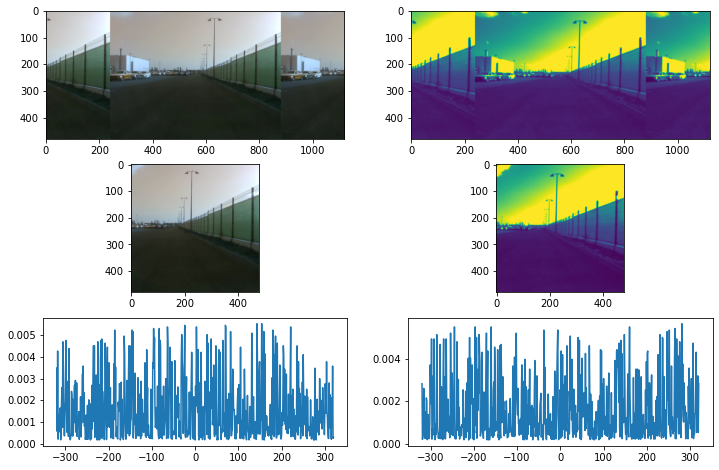

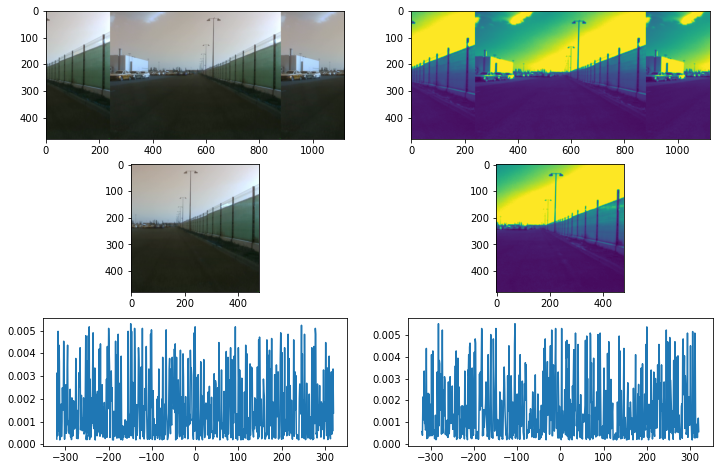

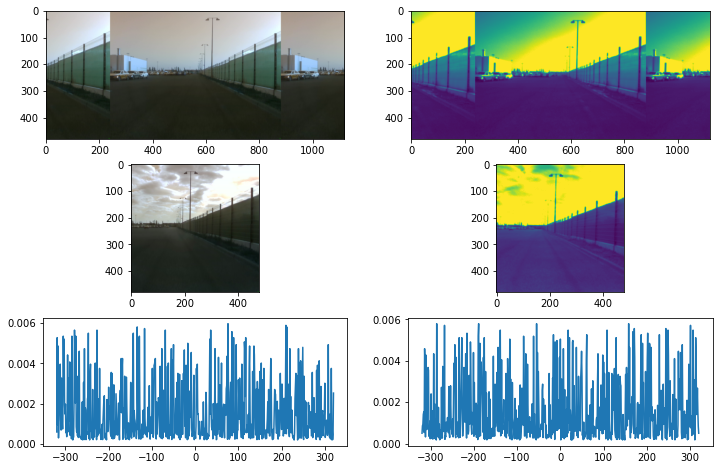

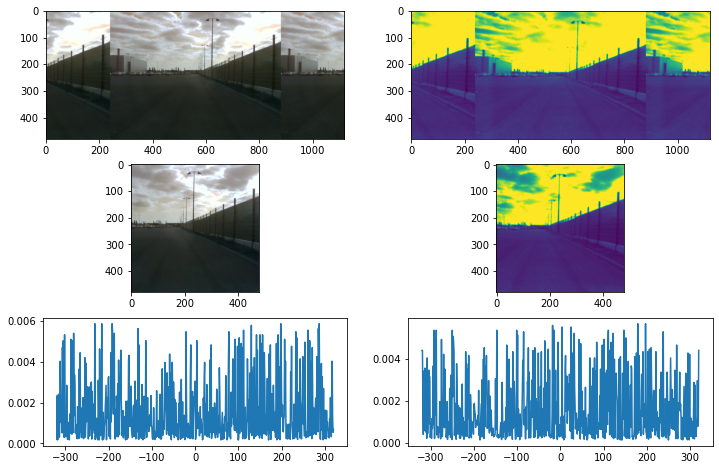

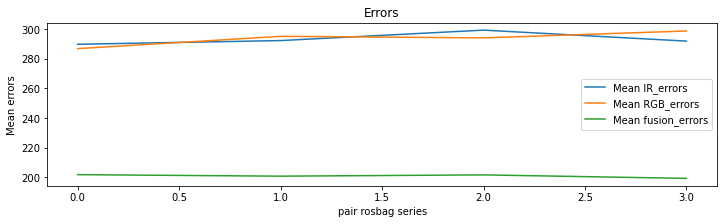

In [9]:
IR_mErrors = []
RGB_mErrors = []
fusion_mErrors = []

for i in range(len(path0_forward_list)-1):
    
    ref_dataset_path = os.path.join(path0_forward_path, path0_forward_list[i])
    emb_dataset_path = os.path.join(path0_forward_path, path0_forward_list[i+1])
    ref_RGB_list, emb_RGB_list, ref_IR_list, emb_IR_list, para = load_dataset(ref_dataset_path, emb_dataset_path)
    batch = para[0]
    
    displacement, likeli_IR, likeli_RGB, likeli_fusion, IR_error, RGB_error, fusion_error = correlate(ref_RGB_list, emb_RGB_list, ref_IR_list, emb_IR_list, para, W_origin, cut_area=0.75)
    vis_result(displacement, para, likeli_IR, likeli_RGB, likeli_fusion, IR_error, RGB_error, fusion_error)
    
    IR_mErrors.append(IR_error.mean())
    RGB_mErrors.append(RGB_error.mean())
    fusion_mErrors.append(fusion_error.mean())
    
plt.figure("Mean errors", figsize = (12,3))
plt.plot(IR_mErrors, label = 'Mean IR_errors')
plt.plot(RGB_mErrors, label = 'Mean RGB_errors')
plt.plot(fusion_mErrors, label = 'Mean fusion_errors')
plt.title("Errors")
plt.xlabel("pair rosbag series")
plt.ylabel("Mean errors")
plt.legend()
plt.show()

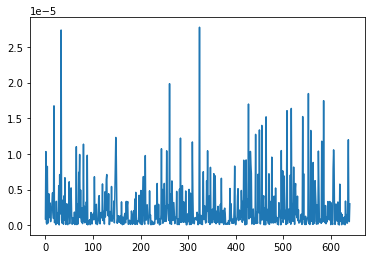

In [25]:
plt.plot(likeli_fusion.reshape(batch,-1).detach().numpy()[0])
plt.show()

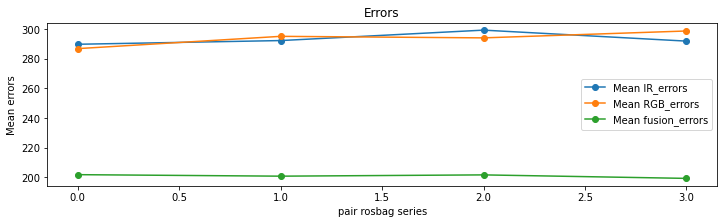

In [11]:
plt.figure("Mean errors", figsize = (12,3))
plt.plot(IR_mErrors, marker='o', label = 'Mean IR_errors')
plt.plot(RGB_mErrors, marker='o', label = 'Mean RGB_errors')
plt.plot(fusion_mErrors, marker='o', label = 'Mean fusion_errors')
plt.title("Errors")
plt.xlabel("pair rosbag series")
plt.ylabel("Mean errors")
plt.legend()
plt.show()